In [86]:
# Import dependencies
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib as plt
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, make_scorer, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier


In [87]:
def load_data(path,target_column,categorical=None,delimiter=','):
    df=pd.read_csv(path,delimiter=delimiter)
    df[target_column] = pd.Categorical(df[target_column])
    df[target_column] = df[target_column].cat.codes
    print(df[target_column].value_counts())
    y=df[target_column]
    X=df.drop(columns=target_column)
    if categorical != None:
        X=pd.get_dummies(X,columns=categorical).astype(int) # I put astype int here because my enviorment has some quirk where get dummies gives boolean values
    X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1,test_size=0.2, stratify=y)
    return X_train,X_test,y_train,y_test

In [88]:
path='Resources/data.csv'
delimiter = ';'
target_column='Target'
categorical=['Marital status','Application mode','Course','Previous qualification','Nacionality',"Mother's qualification","Father's qualification","Mother's occupation","Father's occupation",]
X_train,X_test,y_train,y_test=load_data(path=path,target_column=target_column,categorical=categorical,delimiter=delimiter)
# model dictionary retrieved in optimization process.
model={'id': 4, 'weights': {0: 0.8, 1: 1.5, 2: 0.6}, 'parameters': {'gamma': 0.16265564130892807, 'learning_rate': 0.21852145937893902, 'max_depth': 6, 'reg_lambda': 2, 'subsample': 0.8675099502159194, 'tree_method': 'hist', 'eval_metric': 'aucpr', 'objective': 'multi:softprob', 'random_state': 1, 'num_class': 3, 'device': 'cuda'}, 'f1': 0.5567567567567568, 'recall': 0.6477987421383647, 'precision': 0.4881516587677725, 'full_report': '              precision    recall  f1-score   support\n\n           0       0.84      0.71      0.77       284\n           1       0.49      0.65      0.56       159\n           2       0.85      0.84      0.84       442\n\n    accuracy                           0.76       885\n   macro avg       0.73      0.73      0.72       885\nweighted avg       0.78      0.76      0.77       885\n'}

Target
2    2209
0    1421
1     794
Name: count, dtype: int64


In [89]:
smote=SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
xgb_clf=XGBClassifier(**model['parameters'])
weight_02=class_weight.compute_sample_weight(model['weights'],y=y_resampled)
xgb_clf.fit(X_resampled,y_resampled,sample_weight=weight_02,eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.71098
[1]	validation_0-aucpr:0.71068
[2]	validation_0-aucpr:0.71305
[3]	validation_0-aucpr:0.72378
[4]	validation_0-aucpr:0.72424
[5]	validation_0-aucpr:0.73165
[6]	validation_0-aucpr:0.73014
[7]	validation_0-aucpr:0.72857
[8]	validation_0-aucpr:0.73228
[9]	validation_0-aucpr:0.73390
[10]	validation_0-aucpr:0.73319
[11]	validation_0-aucpr:0.74001
[12]	validation_0-aucpr:0.73866
[13]	validation_0-aucpr:0.74172
[14]	validation_0-aucpr:0.74425
[15]	validation_0-aucpr:0.74652
[16]	validation_0-aucpr:0.74793
[17]	validation_0-aucpr:0.74766
[18]	validation_0-aucpr:0.74818
[19]	validation_0-aucpr:0.75038
[20]	validation_0-aucpr:0.75112
[21]	validation_0-aucpr:0.74987
[22]	validation_0-aucpr:0.75018
[23]	validation_0-aucpr:0.74659
[24]	validation_0-aucpr:0.74630
[25]	validation_0-aucpr:0.74546
[26]	validation_0-aucpr:0.74586
[27]	validation_0-aucpr:0.74678
[28]	validation_0-aucpr:0.74764
[29]	validation_0-aucpr:0.74714
[30]	validation_0-aucpr:0.74744
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.16265564130892807, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.21852145937893902,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [99]:
pred=xgb_clf.predict(X_test)
print(classification_report(y_test,y_pred=pred))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78       284
           1       0.46      0.53      0.49       159
           2       0.82      0.85      0.84       442

    accuracy                           0.75       885
   macro avg       0.71      0.70      0.70       885
weighted avg       0.76      0.75      0.76       885



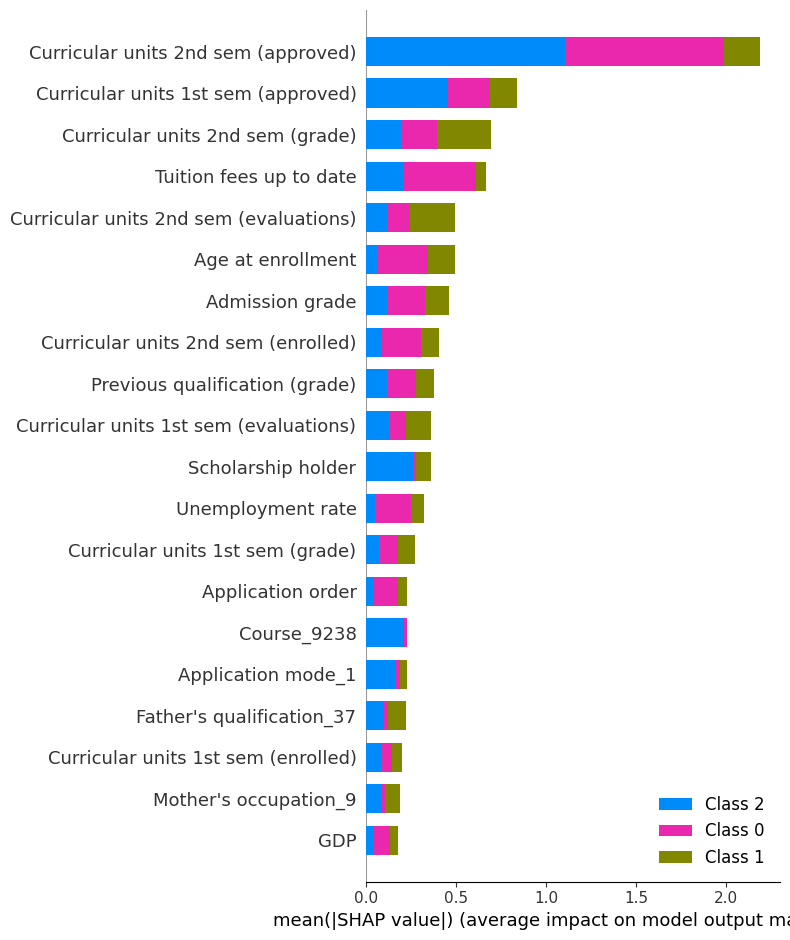

In [90]:
import xgboost as xgb
import matplotlib.pyplot as plt
import shap

# Assuming clf_xgb is your trained XGBoost model
# Feature Importance
# xgb.plot_importance(xgb_clf)
# plt.show()

# SHAP Values
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_train)  # Assuming X_train is your feature set

# Summary plot
shap.summary_plot(shap_values, X_train)


In [93]:
from pdpbox import pdp

feature_name = 'Curricular units 2nd sem (approved)'  # Replace with your actual feature name

# Check if the feature name exists in the DataFrame
if feature_name in X_train.columns:
    # Initialize and create the partial dependence plot using feature name directly
    pdp_dist = pdp.PDPIsolate(
        model=xgb_clf, 
        df=X_train, 
        model_features=X_train.columns, 
        feature=feature_name,
        feature_name=feature_name
    )
    pdp_dist.plot()
    plt.show()
else:
    print(f"Feature not found in DataFrame columns: {feature_name}")


obtain pred_func from the provided model.


100%|██████████| 7/7 [00:01<00:00,  6.22it/s]


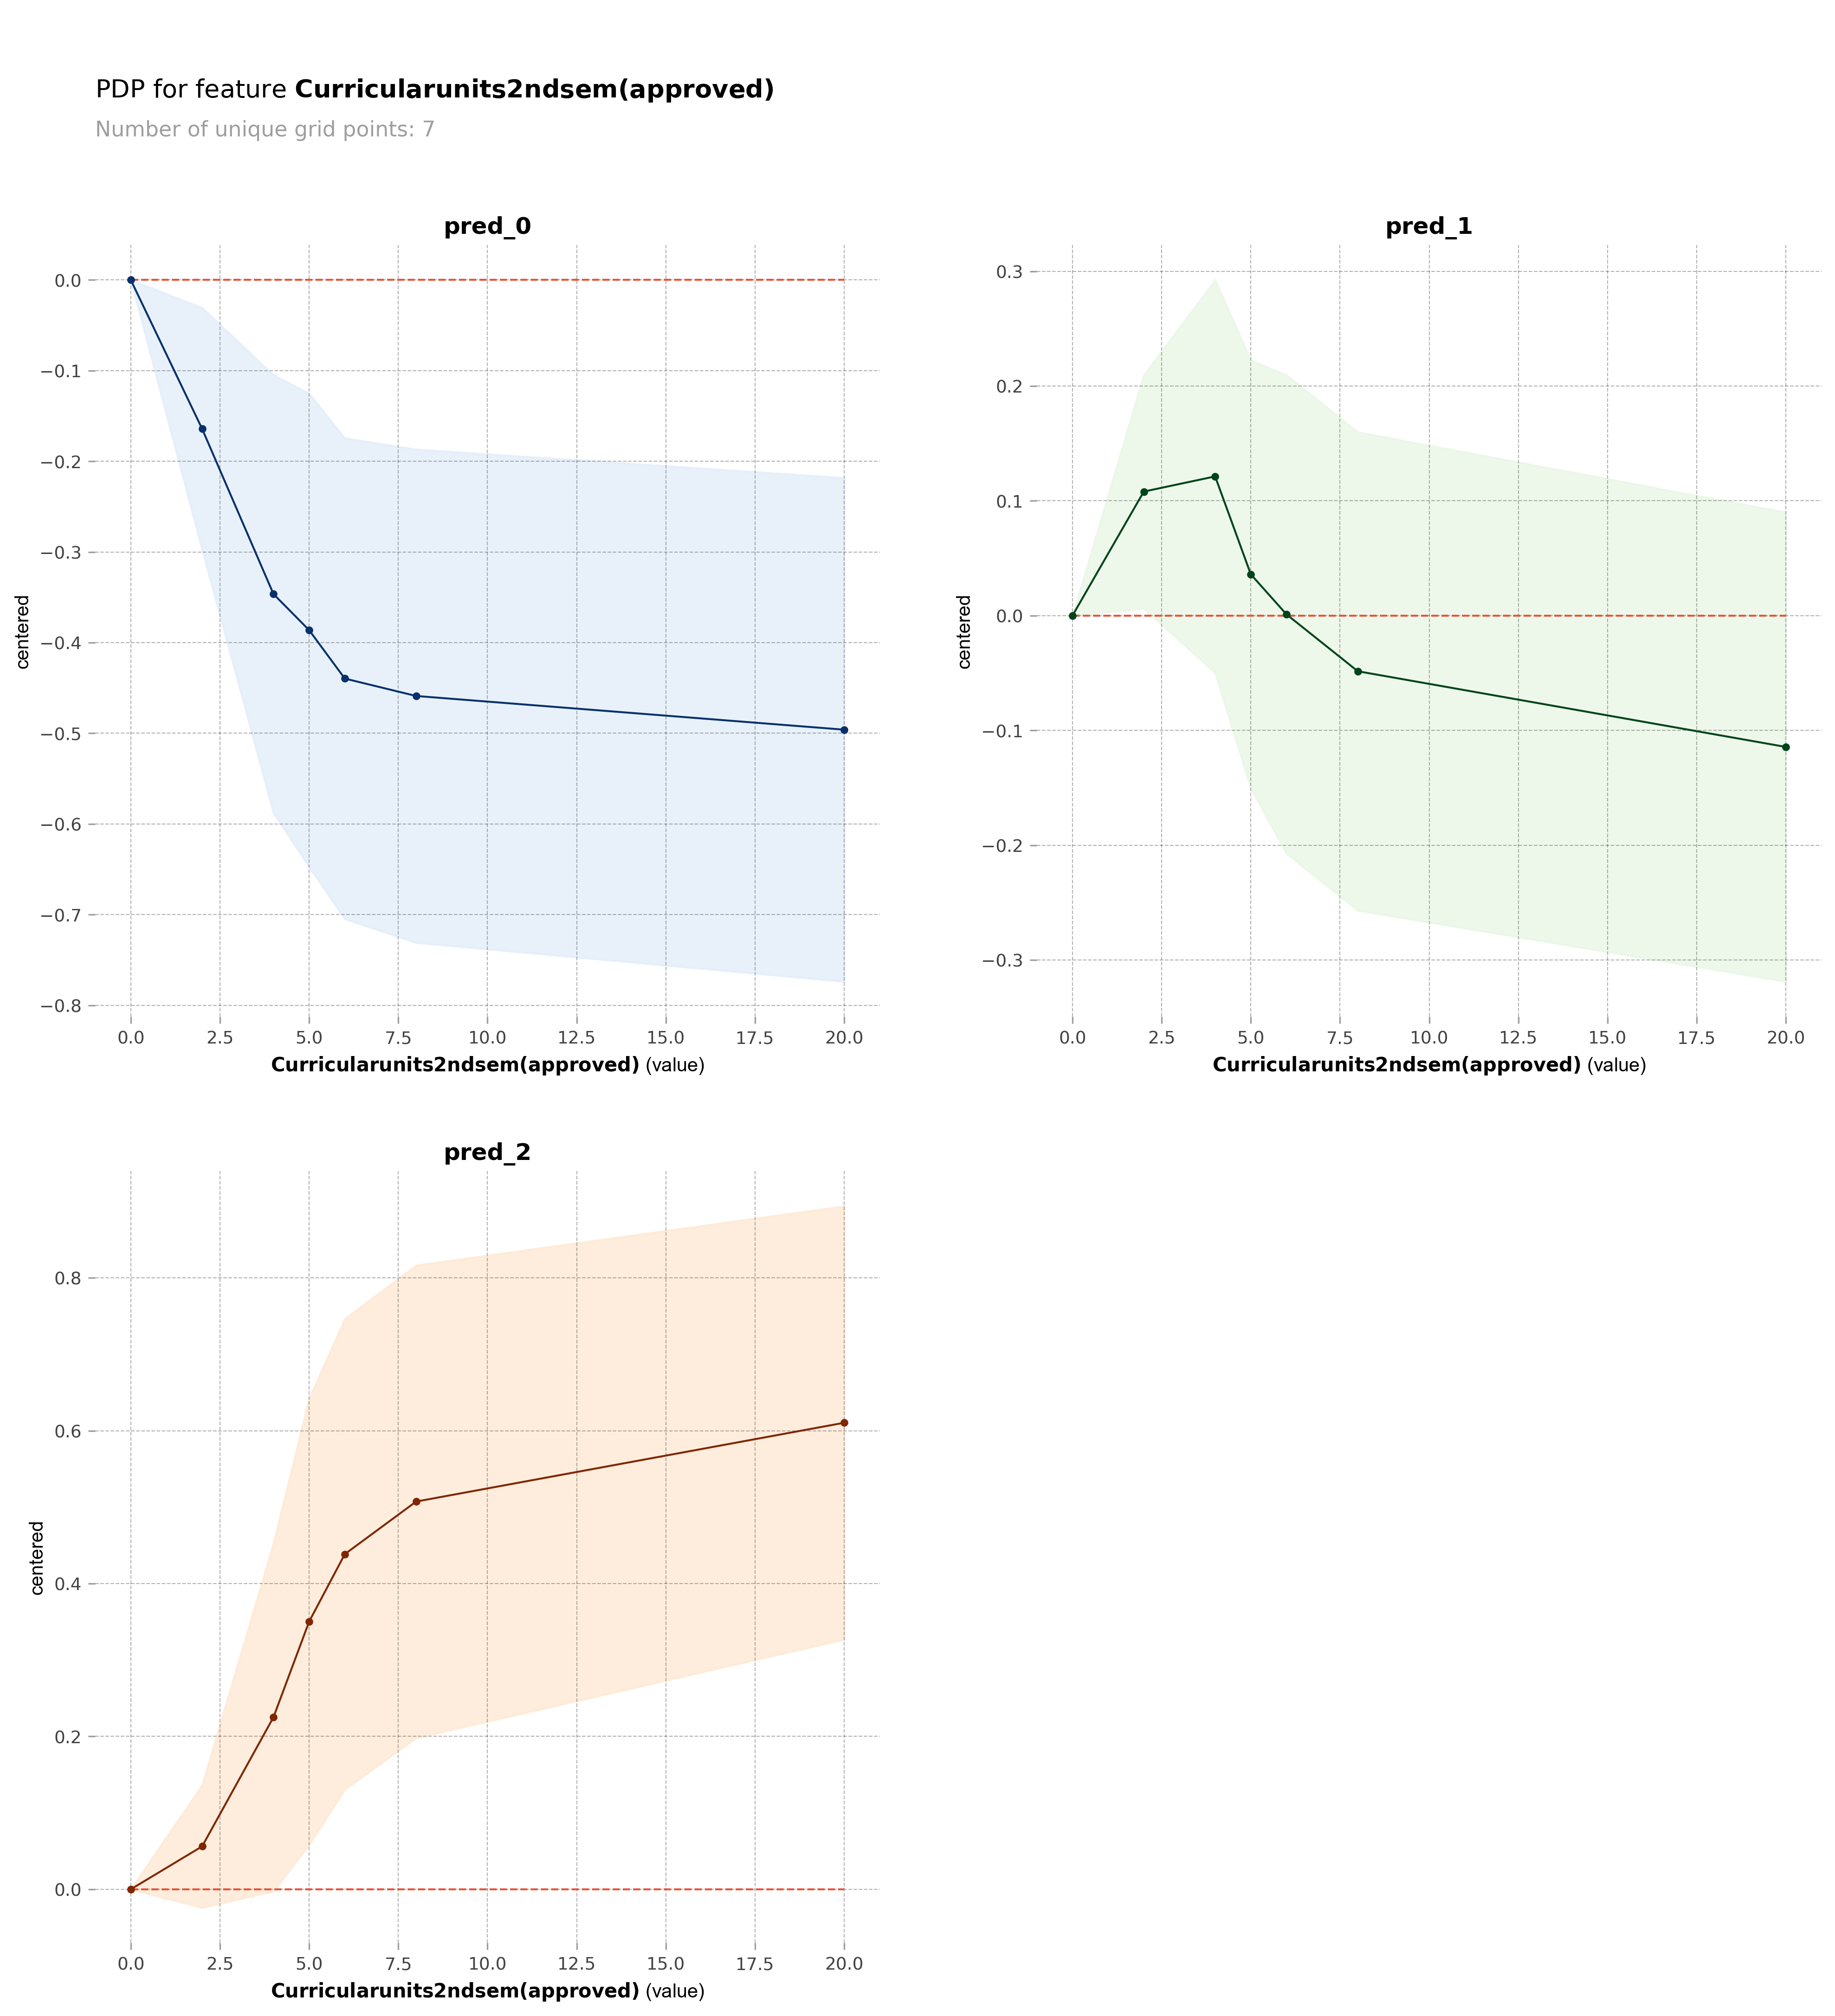

In [94]:
pdp_dist.plot(engine='matplotlib')
plt.show()
